# 추론 기반 기법과 신경망


## 통계 기반 기법의 문제점

통계 기반 기법의 문제점은 대규모 말뭉치를 다룰 때 발생한다.

예를 들어 말뭉치 어휘의 수가 100만개라면, 100만X100만의 거대 희소 행렬에 SVD ($O(n^3)$)를 적용해야하는데 이는 현실적으로 불가능.

- `통계 기반 기법` : 학습 데이터를 한꺼번에 처리 (배치 학습)
- `추론 기반 기법` : 학습 데이터의 일부를 사용하여 순차적으로 학습(미니배치 학습)

미니배치 학습은 계산량이 큰 작업을 처리할 때 효율적. 데이터를 작게 나눠 학습하기 때문에 연산 가능. 또한 병렬 계산도 가능하게 하여 학습 속도 또한 높일 수 있다.

## 추론 기반 기법 개요
```
you ? goodbye and I say hello.
```
문장에서 `?` 을 추론하는 작업. 모델은 이러한 추론 문제를 반복해서 풀면서 **단어의 출현 패턴을 학습**하여 **각 단어 별로 출현 확률을 출력**한다.

## 신경망에서의 단어 처리

신경망을 이용해 단어를 처리하기 위해서는 단어를 **고정 길이의 벡터**로 변환해야 한다. (신경망의 입력층에서 뉴런의 수를 고정해야 함)

대표적인 방법이 `원핫 표현 (one-hot encoding)`

입력층의 각 뉴런이 각 단어에 대응됨

In [1]:
# 완전연결계층에 의한 원핫 인코딩 형식의 단어 변환
# 7개의 단어가 입력으로 들어가고, 이는 3개의 은닉층 뉴런을 통해 변환되어짐
import numpy as np

c = np.array([1, 0, 0, 0, 0, 0, 0]) # 원 핫 입력
W = np.random.randn(7,3) # 가중치
h = np.matmul(c,W) # 중간 노드
print(h)

[0.79430496 1.43159989 0.45691755]


원핫 표현의 단어 ID에 대응하는 원소만 1이고 그 외에는 0인 벡터.

즉, c와 W의 행렬 곱은 **가중치의 행벡터 하나**를 뽑아낸 것과 같다.

때문에 비효율적인 계산 방식. (4장에서 개선)

# 단순한 word2vec

## CBOW 모델의 추론 처리

CBOW <sup>continuous bag-of-words<sup>
    
CBOW 모델은 **맥락으로부터 타깃(target)을 추측**하는 용도의 신경망이다. 

- 타깃 : 중앙 단어
- 맥락 : 중앙 단어의 주변 단어들

<u>맥락이 입력이고 타깃이 출력이다</u>

<img src="../imgs/CBOW.png" width="300" align='left'>

위 그림을 보면 입력층이 4개 있고, 은닉층을 거쳐 출력층에 도달한다. 4개의 입력층에서 은닉층으로의 변환은 완전연결계층 $W_{in}$ 이 처리한다. 그리고 은닉층에서 출력층 뉴런으로의 변환은 다른 완전연결계층 $W_{out}$이 처리한다. 위 그림에서 입력층이 4개인 이유는 맥락으로 고려할 단어를 4개로 정했기 때문. 

---

- 입력층 : 맥락에 포함시킬 단어가 N개라면 입력층도 N개이다.
<br></br>
- 은닉층 : 입력층 전체를 평균낸 값. (SUM / 입력층의 개수)
<br></br>
- 출력층 : 뉴런의 개수 총 7개. 뉴런 하나하나가 각각의 단어에 대응된다. **출력층 뉴런은 각 단어의 '점수'를 뜻하며 값이 높을수록 대응 단어의 출현 확률도 높아진다.** 여기서 점수란 확률로 해석되기 전 값이고, 이 점수에 소프트맥수를 적용해서 확률을 얻을 수 있다.

---

입력층에서 은닉층으로의 변환을 완전연결계층 (가중치 $W_{in}$)이 처리한다. 

이때, (input이 7단어이고 hidden이 3개의 노드를 가질 때) 완전연결계층의 <u>**가중치 $W_{in}$은 $7X3$ 행렬이며, 이 가중치의 각 행이 해당 단어의 분산 표현!</u>**

        you - 0 0 0
        say - 0 0 0
    goodbye - 0 0 0
        and - 0 0 0
          I - 0 0 0
      hello - 0 0 0
          . - 0 0 0 
          
은닉층의 뉴런 수를 입력층의 뉴런 수보다 적게 하는 것이 중요한 핵심이다! 이렇게 해야 은닉층에는 단어 예측에 필요한 정보를 "간결하게" 담게 되며, 결과적으로 밀집벡터 표현을 얻을 수 있다.
          
따라서 **학습을 진행할수록 맥락에서 출현하는 단어(target)를 잘 추측하는 방향으로 이 분산 표현들이 갱신**될 것


In [6]:
## CBOW 모델의 추론 처리, 맥락 2개 모델

import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul

# 샘플 맥락 데이터
# 단어는 7개라고 가정한다.
c0 = np.array([1,0,0,0,0,0,0]) 
c1 = np.array([0,0,1,0,0,0,0])

# 가중치 초기화
W_in = np.random.randn(7,3)
W_out = np.random.randn(3,7)

# 계층 생성
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in) # 가중치 W_in을 공유한다
out_layer = MatMul(W_out)

# 순전파
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h) # 각 단어의 점수 계산

print(s)
# [ 0.11758873  0.00227049 -0.75579113 -0.22458675 -0.3500984  -0.63682774
#  -0.63111001]

[ 0.11758873  0.00227049 -0.75579113 -0.22458675 -0.3500984  -0.63682774
 -0.63111001]


## CBOW 모델의 학습

CBOW 모델은 출력층에서 각 단어의 점수를 출력했다. 이 점수에 소프트맥스 함수를 적용하면 **확률**을 얻을 수 있는데, 

이 확률은 <u>맥락 (전후 단어)이 주어졌었을 때 그 중앙에 어떤 단어가 출현하는 지 </u>를 나타낸다.

CBOW 모델의 학습에서는 올바른 예측을 할 수 있도록 가중치를 조정하는 일을 한다. 

그 결과, 가중치 $W_{in}$ (또한 $W_{out}$ 에도) 에 **단어의 출현 패턴을 파악한 벡터가 학습**된다.

이후 소프트맥스계층과 교차 엔트로피 오차 계층을 통해 손실을 얻어 학습에 사용함.

## word2vec의 가중치와 분산 표현

입력 측 완전연결계층의 가중치 ($W_{in}$)와 출력 측 완전연결계층의 가중치 ($W_{out}$) 둘 다 각 단어의 분산 표현을 가지고 있다.

BUT $W_{out}$에는 단어의 분산표현이 열 방향(수직 방향)으로 저장된다.

$W_{in} = 7X3, W_{out} = 3X7$ 

이때 우리가 활용할 수 있는 선택지는 다음의 세 가지가 있다.

- A. 입력 측의 가중치만 이용 - $W_{in}$
- B. 출력 측의 가중치만 이용 - $W_{out}$
- C. 양쪽 가중치 모두 이용 - ($W_{in},W_{out}$)

**A안인 입력 측 가중치만 이용하는 것이 보편적 방안이다.**

(참고) GloVe에서는 두 가중치를 더했을 때 더 좋은 결과를 얻음

# 학습 데이터 준비

"You say goodbye and I say hello."

## 맥락과 타깃

맥락은 타깃의 주변 단어로, 여러 단어가 될 수 있다.

이때 맨 끝 단어는 고려하지 않음

In [3]:
import sys
sys.path.append('..')
from common.util import preprocess

text = "You say goodbye and I say hello."
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)
print(id_to_word)
# [0 1 2 3 4 1 5 6]
# {0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [8]:
# 말뭉치에서 맥락과 타깃을 만드는 코드
def create_contexts_target(corpus, window_size = 1):
    
    target = corpus[window_size:-window_size] # 맥락의 개수가 채워지지 않는 양 끝 단어는 제외
    contexts = []

    for idx in range(window_size, len(corpus) - window_size):
        cs = [] # context_per_target
        for t in range(-window_size,window_size + 1): # target=0을 기준으로 window_size만큼 좌우 
            if t == 0:
                continue
            cs.append(corpus[idx + t])

        contexts.append(cs)

    return np.array(contexts), np.array(target)

In [5]:
contexts, target = create_contexts_target(corpus,)

print(contexts) # 맥락은 2차원 배열. contexts[0]에는 0번째 맥락이 저장되고,  contexts[1]에는 1번째 맥락이 저장되는 방식.
print("맥락의 형상:",contexts.shape,'\n')
print(target)
print("타깃의 형상:",target.shape)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
맥락의 형상: (6, 2) 

[1 2 3 4 1 5]
타깃의 형상: (6,)


## 원핫 표현으로 변환

In [6]:
def convert_one_hot(corpus, vocab_size):
    
    '''one-hot encoding 으로 변환 
    
    param corpus: 단어 ID목록(1차원 혹은 2차원의 NumPy배열)
    param vocab_size: 어휘수(unique)
    :return: one-hot표현(2차원 혹은 3차원의 NumPy배열)
    ''' 
    N = corpus.shape[0]
    
    if corpus.ndim == 1: # target
        one_hot = np.zeros((N, vocab_size), dtype = np.int32) # unique한 어휘 개수로 one hot length 부여됨.
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1 # 한 단어 당 하나의 one-hot
            
    elif corpus.ndim == 2: # contexts
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype = np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids): # word_id 개수만큼 다시 반복분돌기
                one_hot[idx_0,idx_1,word_id] = 1
                
    return one_hot

In [7]:
print(target)
convert_one_hot(target, 7)

[1 2 3 4 1 5]


array([[0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0]], dtype=int32)

In [8]:
print(contexts)
convert_one_hot(contexts, 7)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]


array([[[1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0]],

       [[0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0]],

       [[0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0]],

       [[0, 0, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0]],

       [[0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1]]], dtype=int32)

In [11]:
import sys
sys.path.append('..')
from common.util import preprocess, create_contexts_target, convert_one_hot

text = "You say goodbye and I say hello."
corpus, word_to_id, id_to_word = preprocess(text)

contexts, target = create_contexts_target(corpus, window_size = 1)

vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

# CBOW 모델 구현

In [10]:
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss

class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size # 인수로 어휘 수와 은닉층의 뉴런 수를 받는다.
        
        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f') # 32비트 부동소수점 수
        W_out = 0.01 * np.random.randn(H, V).astype('f')
        
        # 계층 생성
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in) # 입력 측의 맥락을 처리하는 MatMul 계층은 contexts의 개수만큼 생성 (즉, window_size*2 만큼 생성)
        self.out_layer = MatMul(W_out) # 출력 측의 MatMul 계층 하나
        self.loss_layer = SoftmaxWithLoss() # Softmax with Loss 계층 하나
        
        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
            
        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in
    
    # 신경망의 순전파 메서드
    # 인수로 맥락과 타깃을 받아서 loss를 반환
    def forward(self, contexts, target): 
        # contexts.shape = (6, 2, 7)
        # 0번째 차원의 원소 수 : 미니배치의 수 1번째 차원의 원소 수 : 맥락의 윈도우 크기, 2번째 차원 : 원핫벡터
        
        # target.shape = (6, 7)
        h0 = self.in_layer0.forward(contexts[:,0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss
    
    # 신경망의 역전파 
    def backward(self, dout=1): # 1에서 시작
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

## 학습 코드 구현

| epoch 1 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 2 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 3 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 4 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 5 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 6 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 7 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 8 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 9 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 10 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 11 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 12 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 13 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 14 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 15 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 16 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 17 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 18 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 19 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 20 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 21 |  iter 1 / 2 | ti

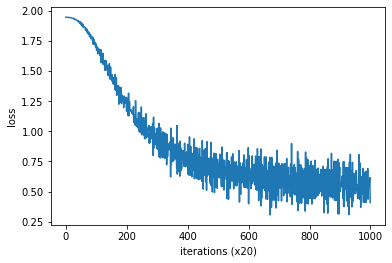

In [15]:
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
from common.trainer import Trainer
from common.optimizer import Adam
from simple_cbow import SimpleCBOW
from common.util import preprocess, create_contexts_target, convert_one_hot

window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = "You say goodbye and I say hello."
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target,vocab_size)
contexts = convert_one_hot(contexts,vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam() # 매개변수 갱신 방법의 한 종류
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()
plt.show()

가로축은 학습 횟수, 세로축은 손실

학습이 경과될수록 손실이 줄어드는 것을 알 수 있다.

In [12]:
# 학습이 끝난 뒤의 가중치 매개변수는 인스턴스 변수 word_vecs에 담겨있음
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word,word_vecs[word_id],end = '\n\n')

you [ 1.3351159 -1.1248811  1.1296217 -1.1195978 -1.0375124]

say [-0.01697864  1.1917418  -1.1481713   1.1842325   1.2066556 ]

goodbye [ 0.61621106 -0.75953335  0.81836444 -0.70477396 -0.8977362 ]

and [-1.8688438   1.0109028  -1.097344    0.9846056   0.96556264]

i [ 0.6094434  -0.76561135  0.8301478  -0.71917397 -0.8725316 ]

hello [ 1.3669877 -1.1133312  1.1342381 -1.1258147 -1.0214459]

. [ 1.6230313   1.0678545  -0.64506924  1.0918348   1.0815095 ]



각 행에는 대응하는 단어 ID에 대한 분산 표현이 저장되어 있다. 단어를 밀집벡터로 표현완료.

# word2vec 보충

## CBOW 모델과 확률

사후확률 $P(A|B)$는 `B가 주어졌을 때 A가 일어날 확률`이다.

$w_1  w_2 .... w_{t-1}  w_{t}  w_{t+1} ... $

이것을 word2vec에 대입하면, <u>맥락 $w_{t-1}과 w_{t+1}$이 주어졌을 때 타깃이 $w_{t}$가 될 확률</u>은 수식으로 $P(w_{t}|w_{t-1},w_{t+1})$ 으로 나타날 수 있다. **====> CBOW**

또한 CBOW 모델의 손실 함수도 간결하게 표현할 수 있다.

1장에서의 교차 엔트로피 오차 식 : $ L = -\sum_{k} t_klog{y_k} $, $t_k$는 k번째 클래스에 해당하는 정답 레이블

수식에서 문제의 정답은 "$w_{t}$의 발생" 이기 때문에 $w_{t}$에 해당하는 원소만 1이고 나머지는 0이 된다. 이점을 감안하면 다음의 손실 식이 도출된다.

$$ L = -logP(w_{t}|w_{t-1},w_{t+1}) $$

## skip-gram 모델

skip-gram은 CBOW에서 다루는 맥락과 타깃을 역전시킨 모델이다.

**CBOW 모델은 맥락이 여러 개 있고, 그 여러 맥락으로부터 중앙의 단어(타깃)을 추측한다.**

     you ? goodbye and I say hello.

**한편, skip-gram 모델은 중앙의 단어(타깃)으로부터 주변의 여러 단어(맥락)을 추측한다.**

     ? say ? and I say hello.
---

<img src="../imgs/skipgram.png" width="250" align='left'>

CBOW와 반대로, skip-gram의 입력층은 하나이고 출력층은 맥락의 수만큼 존재한다. 각 출력층에서는 개별적으로 손실을 구하고, 이 개별 손실들을 모두 더한 값을 최종 손실로 한다.

마찬가지로 skip-gram 모델을 확률 표기로 나타내면, <u>타깃 $w_{t}$가 주어졌을 때 $w_{t-1}$와 $w_{t+1}$가 동시에 일어날 확률을 뜻한다.</u>

$$P(w_{t-1},w_{t+1}|w_{t})$$

skip-gram 모델에서는 맥락의 단어들 사이에 관련성이 없다고 가정하고 다음과 같이 분해한다. (조건부 독립)

$$P(w_{t-1},w_{t+1}|w_{t}) = P(w_{t-1}|w_{t})P(w_{t+1}|w_{t})$$

이어서 skip-gram의 손실 함수를 유도하자.

$ L = -logP(w_{t-1},w_{t+1}|w_{t})$ 

$ =-logP(w_{t-1}|w_{t})P(w_{t+1}|w_{t}) $

$ = -(logP(w_{t-1}|w_{t}) + log(P(w_{t+1}|w_{t}))$

식에서도 알 수 있듯, skip-gram 모델의 손실 함수는 맥락 별로 손실을 구한 다음에 모두 더한다. 

## CBOW vs. skip-gram

둘 중 어느 모델을 사용해야 할까? **답은 skip-gram 모델이다.**

단어 분산 표현의 정밀도 면에서 skip-gram 모델의 결과가 더 좋은 경우가 많다. 특히, 말뭉치가 커질수록 이러한 경향성은 커진다. 

반면, 학습 속도 면에서는 CBOW 모델이 더 빠르다.skip-gram 모델은 손실을 맥락의 수만큼 구해야 해서 계산 비용이 그만큼 커지게 된다. 

skip-gram 모델은 하나의 단어로부터 그 주변 단어를 예측. skip-gram 모델이 CBOW 모델보다 더 어려운 문제를 예측한다고 볼 수 있다. 더 어려운 상황에서 학습하는 만큼 skip-gram 모델로부터 생성된 단어의 분산 표현이 더 정교하고 뛰어날 가능성이 커진다고도 생각해볼 수 있다.

In [18]:
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss

# skip-gram 구현
class SimpleSkipGram:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # 계층 생성
        self.in_layer = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer1 = SoftmaxWithLoss() # CBOW와는 반대로 출력층에 맥락의 개수만큼 레이어 생성
        self.loss_layer2 = SoftmaxWithLoss()

        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 단어의 분산 표현 저장
        self.word_vecs = W_in # skip-gram에서도 동일하게 인풋 가중치 사용

    def forward(self, contexts, target):
        h = self.in_layer.forward(target)
        s = self.out_layer.forward(h)
        l1 = self.loss_layer1.forward(s, contexts[:, 0])
        l2 = self.loss_layer2.forward(s, contexts[:, 1])
        loss = l1 + l2 # 모든 맥락의 손실을 합친 것이 skip-gram의 손실
        return loss

    def backward(self, dout=1):
        dl1 = self.loss_layer1.backward(dout)
        dl2 = self.loss_layer2.backward(dout)
        ds = dl1 + dl2
        dh = self.out_layer.backward(ds)
        self.in_layer.backward(dh)
        return None

## 통계 기반 vs. 추론 기반

**1. 어휘에 추가할 새 단어가 생겨서 단어의 분산 표현을 갱신해야 하는 상황**

통계 기반 기법 : 계산을 처음부터 다시 해야한다. 단어의 분산 표현을 조금만 수정하고 싶어도, 동시발생 행렬을 다시 만들고 SVD를 수행하는 일련의 작업을 다시 해야 한다. 

추론 기반 기법 : 매개변수를 다시 학습할 수 있다. 지금까지 학습한 가중치를 초깃값으로 사용해 다시 학습하면 되는데, 이런 특성 덕분에 기존에 학습한 경험을 해치지 않으면서 단어의 분산 표현을 효율적으로 갱신할 수 있다.


**2. 두 기법으로 얻는 단어의 분산 표현의 성격이나 정밀도 측면**

통게 기반 기법 : 주로 단어의 유사성이 인코딩된다. 

추론 기반 기법 : 단어의 유사성 뿐만 아니라, 그리고 복잡한 단어 사이의 패턴도 파악되어 인코딩된다.

BUT, 실제로 단어의 유사성을 정량적으로 평가해본 연구 결과에서, 추론 기반과 통계 기반 기법의 우열을 가릴 수 없었다.

**두 기법은 사실 상 연관되어 있다**

구체적으로는 skip-gram + negative sampling을 이용한 모델은 동시발생 행렬에 특수한 행렬 분해를 적용한 것과 같다.

**GloVe**

==> 추론 기반 기법 + 통계 기반 기법

말뭉치 전체의 통계 정보를 손실 함수에 도입해 미니배치 학습을 하는 것. 